# Limpieza de: Tabla_game.csv

Explorar dimensiones (shape) y columnas.

Identificar claves principales (game_id, team_id, player_id).

Normalizar nombres de jugadores si aplica.

Revisar y transformar fechas (game_date).

Detectar métricas clave de rendimiento (minutos, puntos, rebotes, asistencias, etc.).

Evaluar nulos y consistencia.


In [1]:
import pandas as pd
import numpy as np

# Cargar tabla game
df_game = pd.read_csv(r"C:\Users\elian\OneDrive\Escritorio\NBA_ComposicionCorporal_Rendimiento\data\game.csv")

# Tamaño y primeras filas
print("Shape:", df_game.shape)
print(df_game.head(3))

# Info general
print(df_game.info())

# Nulos por columna
print(df_game.isna().sum())

# Valores únicos en cada columna (solo para columnas clave)
for col in df_game.columns[:10]:  # limitar a primeras 10 para no saturar
    print(f"\nColumna: {col}")
    print(df_game[col].unique()[:10])  # primeros 10 valores únicos

Shape: (65698, 55)
   season_id  team_id_home team_abbreviation_home           team_name_home  \
0      21946    1610610035                    HUS          Toronto Huskies   
1      21946    1610610034                    BOM        St. Louis Bombers   
2      21946    1610610032                    PRO  Providence Steamrollers   

    game_id            game_date matchup_home wl_home  min  fgm_home  ...  \
0  24600001  1946-11-01 00:00:00  HUS vs. NYK       L    0      25.0  ...   
1  24600003  1946-11-02 00:00:00  BOM vs. PIT       W    0      20.0  ...   
2  24600002  1946-11-02 00:00:00  PRO vs. BOS       W    0      21.0  ...   

   reb_away  ast_away  stl_away  blk_away  tov_away  pf_away  pts_away  \
0       NaN       NaN       NaN       NaN       NaN      NaN      68.0   
1       NaN       NaN       NaN       NaN       NaN     25.0      51.0   
2       NaN       NaN       NaN       NaN       NaN      NaN      53.0   

   plus_minus_away  video_available_away     season_type  
0  

Dimensiones: 65.698 registros, 55 columnas.

Claves principales: game_id (único por partido), team_id_home, team_id_away.

Fechas: game_date está en formato texto y debe convertirse a datetime.

Resultados: columnas de resultado (wl_home, wl_away) contienen valores W, L y algunos nulos.

Métricas de juego: tiros, rebotes, asistencias, robos, pérdidas, etc., separadas para home y away. Varias con muchos nulos (ej. estadísticas defensivas en temporadas antiguas).

Valores atípicos: la columna min muestra valores poco realistas (0, 265, 365…), requiere validación ya que un partido oficial dura 48 minutos.

Variables duplicadas por condición local/visitante: patrón repetido (*_home, *_away). Esto permite análisis comparativos pero aumenta el ancho de la tabla.

## Revisar dimensiones y tipos de datos.

Convertir fechas a formato datetime.

Crear columna binaria home_win.

Revisar consistencia entre wl_home y los puntos.

Generar un describe() de las métricas principales.

In [2]:
# === FECHAS ===
df_game["game_date"] = pd.to_datetime(df_game["game_date"], errors="coerce")

# === RESULTADOS ===
# Variable binaria: 1 si gana local, 0 si pierde
df_game["home_win"] = (df_game["pts_home"] > df_game["pts_away"]).astype(int)

# Chequeo de consistencia con wl_home
consistency_check = (df_game["wl_home"] == "W").mean()
print("Consistencia wl_home vs puntos:", round(consistency_check*100, 2), "%")

# === ESTADÍSTICAS PRINCIPALES ===
cols_stats = [
    "pts_home", "pts_away",
    "reb_home", "reb_away",
    "ast_home", "ast_away",
    "stl_home", "stl_away",
    "blk_home", "blk_away",
    "tov_home", "tov_away",
    "fg_pct_home", "fg_pct_away",
    "fg3_pct_home", "fg3_pct_away",
    "ft_pct_home", "ft_pct_away"
]

print("\nEstadísticos descriptivos (principales métricas):")
print(df_game[cols_stats].describe().T)

# === NULOS ===
print("\nNulos en métricas principales:")
print(df_game[cols_stats].isna().sum())



Consistencia wl_home vs puntos: 61.87 %

Estadísticos descriptivos (principales métricas):
                count        mean        std     min     25%      50%  \
pts_home      65698.0  104.619136  14.757924  18.000  95.000  105.000   
pts_away      65698.0  100.991567  14.418755  19.000  92.000  101.000   
reb_home      49969.0   43.761432   7.087954   0.000  39.000   43.000   
reb_away      49973.0   42.119645   6.867396   0.000  37.000   42.000   
ast_home      49893.0   23.940994   5.694053   0.000  20.000   24.000   
ast_away      49897.0   22.135419   5.380805   0.000  18.000   22.000   
stl_home      46849.0    7.991782   3.110087   0.000   6.000    8.000   
stl_away      46849.0    7.854148   3.031766   0.000   6.000    8.000   
blk_home      47072.0    5.313690   2.768968   0.000   3.000    5.000   
blk_away      47073.0    4.681537   2.500820   0.000   3.000    4.000   
tov_home      47014.0   14.782724   4.140004   0.000  12.000   15.000   
tov_away      47013.0   15.199860

## Consistencia resultados

Solo 61.9 % de concordancia entre wl_home y los puntos (pts_home > pts_away). Hay errores en la variable wl_home, conviene priorizar los puntos como verdad.

Distribución de puntos: Locales (104.6) anotan un poco más que visitantes (101).

Rebotes y asistencias: Muestras con medias similares entre local y visitante.

Porcentajes:

FG%: 46.7 % (home) vs 45.5 % (away).

3P%: 34.6 % (home) vs 33.7 % (away).

FT%: ~75 % en ambos casos.

### Nulos relevantes:

Rebotes, asistencias, robos, tapones y pérdidas: ~15–18k nulos (~30 %).

FG% y FG3%: también con >15k nulos.

FT%: ~3k nulos (~5 %).

Valores atípicos: Existen máximos imposibles (ej. FG% > 1, FT% > 1). Deben corregirse o eliminarse.

### Próximos pasos

Definir variable de resultado confiable: mantener home_win basado en puntos, descartar wl_home.

Revisar y limpiar nulos: imputar solo donde sea razonable (ej. FT% = 0 si fta = 0), el resto descartar filas.

Normalizar métricas: filtrar outliers irreales (FG% > 1.2, FT% > 1.2).

Guardar versión limpia (game_ready.csv) para poder enlazar luego con jugadores/equipos.

## Limpieza inicial game

Nueva variable de resultado (home_win)

Se crea a partir de los puntos (pts_home > pts_away).

Razón: wl_home tenía errores → no es confiable.

Eliminación de columnas (wl_home, wl_away)

Son redundantes ahora que tenemos home_win.

Corrección de outliers en porcentajes

Valores como FG% > 1.2 o FT% > 1.2 son imposibles (100 % máximo).

Se reemplazan por NaN para no contaminar el análisis.

Revisión de nulos post-limpieza

Se contabilizan los faltantes para decidir imputación o eliminación.

In [3]:
# === LIMPIEZA INICIAL GAME ===

# 1. Crear variable confiable de resultado (home_win) a partir de puntos
df_game["home_win"] = (df_game["pts_home"] > df_game["pts_away"]).astype(int)

# 2. Eliminar la columna wl_home (no confiable)
df_game = df_game.drop(columns=["wl_home", "wl_away"])

# 3. Corregir valores imposibles en porcentajes
#    (ej: fg_pct > 1.2, ft_pct > 1.2 se consideran inválidos → NaN)
for col in ["fg_pct_home", "fg_pct_away", "fg3_pct_home", "fg3_pct_away",
            "ft_pct_home", "ft_pct_away"]:
    df_game.loc[df_game[col] > 1.2, col] = np.nan

# 4. Resumen de nulos después de correcciones
print("Nulos tras limpieza inicial:")
print(df_game[[
    "pts_home", "pts_away", "reb_home", "reb_away", "ast_home", "ast_away",
    "stl_home", "stl_away", "blk_home", "blk_away", "tov_home", "tov_away",
    "fg_pct_home", "fg_pct_away", "fg3_pct_home", "fg3_pct_away",
    "ft_pct_home", "ft_pct_away"
]].isna().sum())

# 5. Verificar consistencia de la nueva variable
print("\nEjemplo home_win calculado:")
print(df_game[["pts_home", "pts_away", "home_win"]].head(10))


Nulos tras limpieza inicial:
pts_home            0
pts_away            0
reb_home        15729
reb_away        15725
ast_home        15805
ast_away        15801
stl_home        18849
stl_away        18849
blk_home        18626
blk_away        18625
tov_home        18684
tov_away        18685
fg_pct_home     15490
fg_pct_away     15490
fg3_pct_home    19074
fg3_pct_away    18962
ft_pct_home      3016
ft_pct_away      3016
dtype: int64

Ejemplo home_win calculado:
   pts_home  pts_away  home_win
0      66.0      68.0         0
1      56.0      51.0         1
2      59.0      53.0         1
3      63.0      47.0         1
4      33.0      50.0         0
5      71.0      60.0         1
6      56.0      71.0         0
7      55.0      57.0         0
8      49.0      53.0         0
9      73.0      65.0         1


Resultados de la limpieza inicial en game

Variable home_win

Crea una medida confiable de victorias locales basada en puntos (pts_home > pts_away).

Reemplaza a wl_home, que tenía inconsistencias.

Nulos detectados

Puntos (pts_home, pts_away): completos en todos los registros.

Estadísticas modernas (reb, ast, stl, blk, tov, fg%, fg3%, ft%): presentan entre 15k y 19k valores nulos.

La causa es histórica: muchas métricas no se registraban en las primeras décadas de la liga.

Acciones realizadas

Eliminación de columnas inconsistentes (wl_home, wl_away).

Corrección de outliers imposibles en porcentajes (FG% > 1.2, FT% > 1.2 → NaN).

## Objetivo

Detectar en qué temporadas (season_id) empiezan a aparecer datos completos de rebotes, asistencias, robos, tapas, pérdidas y porcentajes de tiro.

Esto nos ayudará a decidir si trabajar:

con todo el histórico (aceptando huecos), o

con un corte moderno (dataset más limpio y comparable).

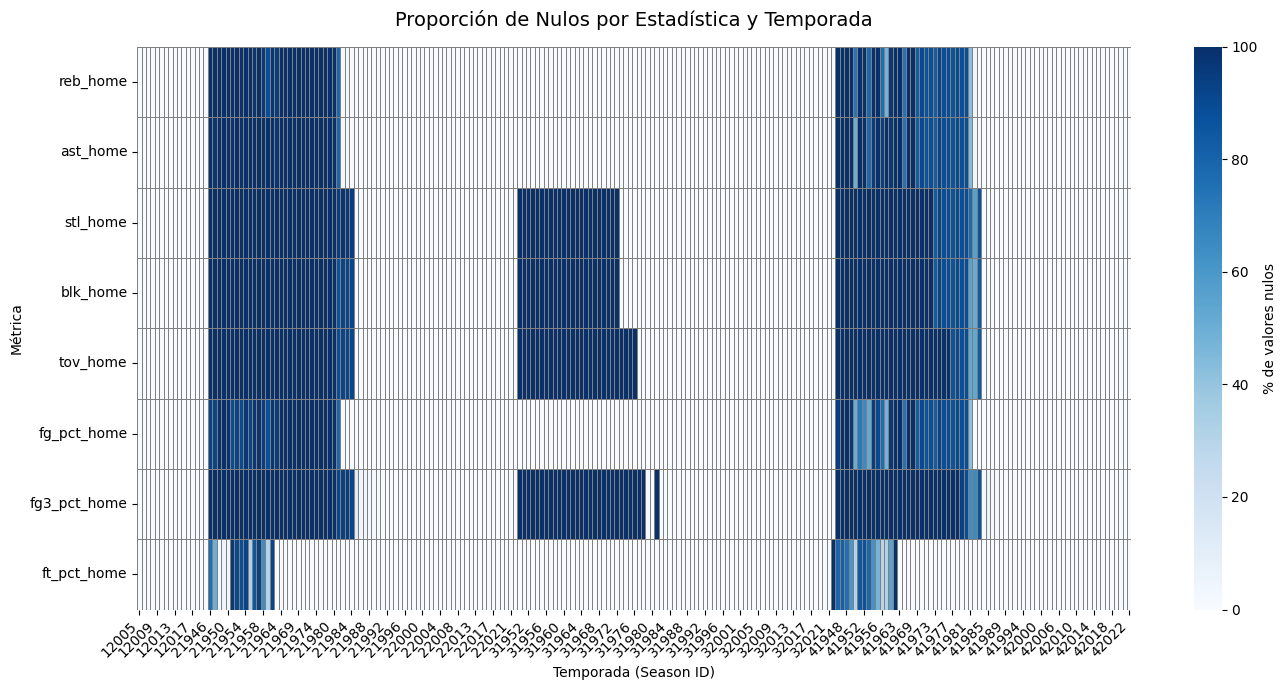

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Columnas a analizar
cols_check = [
    "reb_home", "ast_home", "stl_home", "blk_home", "tov_home",
    "fg_pct_home", "fg3_pct_home", "ft_pct_home"
]

# Calcular proporción de nulos por temporada
nulls_by_season = df_game.groupby("season_id")[cols_check].apply(lambda x: x.isna().mean() * 100)

# Visualizar como heatmap
plt.figure(figsize=(14,7))
sns.heatmap(
    nulls_by_season.T,
    cmap="Blues",
    cbar_kws={'label': '% de valores nulos'},
    linewidths=0.5,
    linecolor="gray",
    annot=False  # poner True si querés números
)
plt.title("Proporción de Nulos por Estadística y Temporada", fontsize=14, pad=15)
plt.xlabel("Temporada (Season ID)")
plt.ylabel("Métrica")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Análisis de la tabla game – Nulos por temporada
Hallazgos principales

Robos (STL) y tapones (BLK): No se registraban hasta la temporada 1973-74, lo que explica los valores nulos al inicio del dataset.

Pérdidas (TOV): Recién comienzan a medirse en la temporada 1977-78.

Tiro de tres puntos (FG3%): Aparece como métrica oficial a partir de la temporada 1979-80.

Rebotes y asistencias: Existen desde el inicio, pero con registros incompletos en las primeras décadas.

Porcentajes de tiro (FG%, FT%): Aunque ya presentes, muestran inconsistencias en temporadas antiguas.

Implicancias para el análisis

Si se incluye todo el histórico (1946–actualidad), debe contemplarse la ausencia sistemática de métricas en las primeras décadas.

Para un análisis robusto y comparable en todas las métricas, se recomienda trabajar desde la temporada 1979-80, cuando se incorporan triples y pérdidas de balón.

Decisión sugerida

Definir dos datasets de trabajo:

Histórico completo: útil para tendencias de largo plazo (puntos, rebotes, victorias).

Moderno (1979–actualidad): garantiza comparabilidad en todas las estadísticas avanzadas.

In [6]:
output_path = r"C:\Users\elian\OneDrive\Escritorio\NBA_ComposicionCorporal_Rendimiento\data_clean\game_ready.csv"
df_game.to_csv(output_path, index=False)
print(f"Archivo guardado en: {output_path}")


Archivo guardado en: C:\Users\elian\OneDrive\Escritorio\NBA_ComposicionCorporal_Rendimiento\data_clean\game_ready.csv


In [7]:
df_check = pd.read_csv(output_path)
print(df_check.shape)
print(df_check.head())


(65698, 54)
   season_id  team_id_home team_abbreviation_home           team_name_home  \
0      21946    1610610035                    HUS          Toronto Huskies   
1      21946    1610610034                    BOM        St. Louis Bombers   
2      21946    1610610032                    PRO  Providence Steamrollers   
3      21946    1610610025                    CHS            Chicago Stags   
4      21946    1610610028                    DEF          Detroit Falcons   

    game_id   game_date matchup_home  min  fgm_home  fga_home  ...  ast_away  \
0  24600001  1946-11-01  HUS vs. NYK    0      25.0       NaN  ...       NaN   
1  24600003  1946-11-02  BOM vs. PIT    0      20.0      59.0  ...       NaN   
2  24600002  1946-11-02  PRO vs. BOS    0      21.0       NaN  ...       NaN   
3  24600004  1946-11-02  CHS vs. NYK    0      21.0       NaN  ...       NaN   
4  24600005  1946-11-02  DEF vs. WAS    0      10.0       NaN  ...       NaN   

   stl_away  blk_away  tov_away  pf_aw